In [2]:
import numpy as np
import bisect

from matplotlib import pyplot as plt
import matplotlib

In [3]:
from pixel2d import Pixel2D

In [4]:
from topologicalunionfind import TopologicalUnionFind

### Reading Slice

In [4]:
aslice = np.array([[1,3,8], [5,7,6], [9,4,2]])
aslice

array([[1, 3, 8],
       [5, 7, 6],
       [9, 4, 2]])

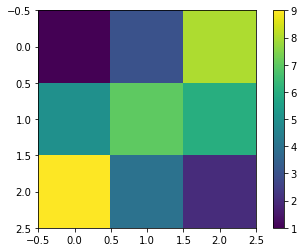

In [5]:
plt.imshow(aslice)
plt.colorbar()
plt.show()

### Getting Data

In [6]:
reverse = True
diagonal = False

In [7]:
if reverse:
    data = aslice.max() - aslice + 1
else:
    data = aslice
data.shape

(3, 3)

In [8]:
data

array([[9, 7, 2],
       [5, 3, 4],
       [1, 6, 8]])

### Generating Input File

In [206]:
if reverse: 
    if diagonal:
        ainput = 'toy2dr.txt'
    else:
        ainput = 'toy2dr2.txt'
else:
    if diagonal:
        ainput = 'toy2d.txt'
    else:
        ainput = 'toy2d2.txt'

In [207]:
def write2dPath(f, data, i, j, ni, nj):
    if ni < 0 or nj < 0:
        return
    try:
        f.write('1 {} {} {} {} {}\n'.format(i, j, ni, nj, max(data[i, j], data[ni, nj])))
    except:
        pass

In [208]:
with open(ainput, 'w') as f:
    f.write(str(len(data.shape))+'\n')
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            f.write('0 {} {} {}\n'.format(i, j, data[i, j]))
            write2dPath(f, data, i, j, i+1, j)
            write2dPath(f, data, i, j, i, j+1)
            if diagonal:
                write2dPath(f, data, i, j, i+1, j+1)
                write2dPath(f, data, i, j, i+1, j-1)

### Running

In [209]:
import subprocess

In [210]:
subprocess.run(['./perseusMac', 'nmfsimtop', ainput, ainput[:-4]])

CompletedProcess(args=['./perseusMac', 'nmfsimtop', 'toy2dr2.txt', 'toy2dr2'], returncode=0)

### Reading Output File

In [211]:
if reverse: 
    if diagonal:
        aoutput = 'toy2dr_0.txt'
    else:
        aoutput = 'toy2dr2_0.txt'
else:
    if diagonal:
        aoutput = 'toy2d_0.txt'
    else:
        aoutput = 'toy2d2_0.txt'

In [212]:
pd2 = []
with open(aoutput) as f:
    for l in f.readlines():
        info = l.split()
        pd2.append((int(info[0]), int(info[1])))
pd2 = sorted(pd2, key=lambda x:x[0])
pd2

[(1, -1), (2, 5), (3, 4)]

In [213]:
persistencePH = []
for birth, death in pd2:
    if reverse:
        nbirth = aslice.max() - death + 1 if death != -1 else aslice.min() 
        ndeath = aslice.max() - birth + 1
    else:
        nbirth = birth + aslice.min() - 1
        ndeath = death + aslice.min() - 1 if death != -1 else aslice.max()
    persistencePH.append((nbirth, ndeath))
persistencePH

[(1, 9), (5, 8), (6, 7)]

### Creating Pixel Objects

In [9]:
mat = []
for i in range(data.shape[0]):
    row = []
    for j in range(data.shape[1]):
        element = data[i][j]
        row.append(Pixel2D(i, j, element))
    mat.append(row)

In [10]:
arr = sorted([e for row in mat for e in row])
arr

[Pixel: [coordinates: (2, 0); value: 1],
 Pixel: [coordinates: (0, 2); value: 2],
 Pixel: [coordinates: (1, 1); value: 3],
 Pixel: [coordinates: (1, 2); value: 4],
 Pixel: [coordinates: (1, 0); value: 5],
 Pixel: [coordinates: (2, 1); value: 6],
 Pixel: [coordinates: (0, 1); value: 7],
 Pixel: [coordinates: (2, 2); value: 8],
 Pixel: [coordinates: (0, 0); value: 9]]

### Getting Neighbors for a Pixel

In [11]:
def append2DNeighbor(neighbors, x, y):
    if x < 0 or y < 0:
        return
    try:
        neighbors.append(mat[x][y])
    except:
        pass

In [12]:
def get_neighbors(pixel, diagonal=False):
    neighbors = []
    x = pixel.getX()
    y = pixel.getY()
    append2DNeighbor(neighbors, x-1, y)
    append2DNeighbor(neighbors, x+1, y)
    append2DNeighbor(neighbors, x, y-1)
    append2DNeighbor(neighbors, x, y+1)
    if diagonal:
        append2DNeighbor(neighbors, x-1, y-1)
        append2DNeighbor(neighbors, x-1, y+1)
        append2DNeighbor(neighbors, x+1, y-1)
        append2DNeighbor(neighbors, x+1, y+1)
    return neighbors

In [13]:
set([len(get_neighbors(pixel)) for pixel in arr])

{2, 3, 4}

In [14]:
set([len(get_neighbors(pixel, True)) for pixel in arr])

{3, 5, 8}

### Creating Topological Union-find

In [15]:
tuf = TopologicalUnionFind()
tuf

<UnionFind:
	elts=[],
	siz=[],
	par=[],
n_elts=0,n_comps=0>

In [16]:
for pixel in arr:
    tuf.add(pixel, pixel.getV())
    for neighbor in get_neighbors(pixel, diagonal):
        tuf.union(pixel, neighbor, pixel.getV())

In [17]:
pd = tuf.persistence()
pd

[(1, inf), (2, 5), (3, 4)]

In [18]:
persistenceUF = []
for birth, death in pd:
    if reverse:
        nbirth = aslice.max() - death + 1 if np.isfinite(death) else aslice.min() 
        ndeath = aslice.max() - birth + 1
    else:
        nbirth = birth
        ndeath = death if np.isfinite(death) else aslice.max()
    persistenceUF.append((nbirth, ndeath))
persistenceUF

[(1, 9), (5, 8), (6, 7)]

### Visualization

In [224]:
y = np.arange(0, len(persistenceUF))

In [225]:
xmin = [birth for birth, death in persistenceUF]
xmax = [death for birth, death in persistenceUF]

In [226]:
if reverse:
    xlim = (max(xmax), min(xmin))
else:
    xlim = (min(xmin), max(xmax))

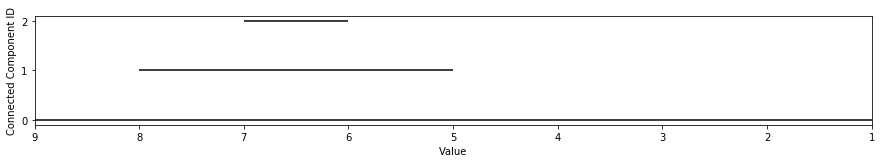

In [227]:
height = 2 + len(persistenceUF) // 10
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()

In [228]:
xmin = [birth for birth, death in persistenceUF]
xmax = [death for birth, death in persistenceUF]

In [229]:
if reverse:
    xlim = (max(xmax)+1, min(xmin)-1)
    xmin, xmax = xmax, xmin
else:
    xlim = (min(xmin)-1, max(xmax)+1)

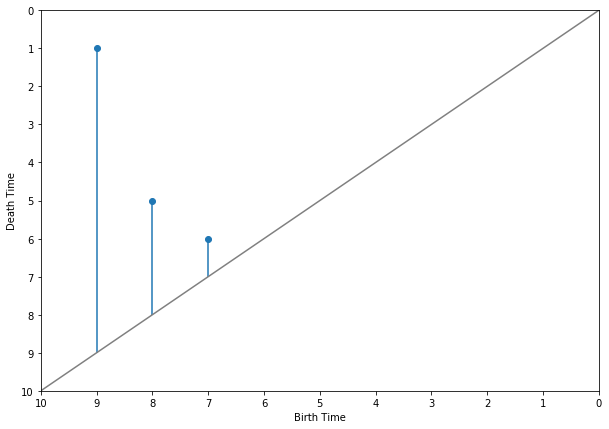

In [230]:
plt.figure(figsize=(10,7))
plt.scatter(xmin, xmax)
plt.vlines(x=xmin, ymin=xmin, ymax=xmax, colors='C0')
plt.xlim(xlim[0], xlim[1])
plt.ylim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Birth Time')
plt.ylabel('Death Time')
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], c='grey')
plt.show()

### Visualization2

In [231]:
y = np.arange(0, len(persistencePH))

In [232]:
xmin = [birth for birth, death in persistencePH]
xmax = [death for birth, death in persistencePH]

In [233]:
if reverse:
    xlim = (max(xmax), min(xmin))
else:
    xlim = (min(xmin), max(xmax))

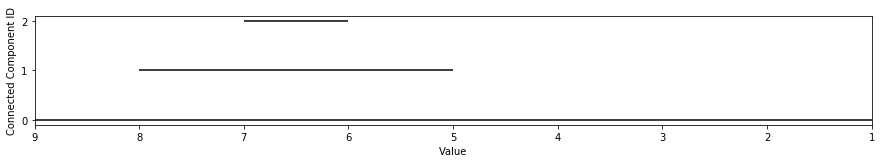

In [234]:
height = 2 + len(persistencePH) // 10
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()

In [235]:
xmin = [birth for birth, death in persistencePH]
xmax = [death for birth, death in persistencePH]

In [236]:
if reverse:
    xlim = (max(xmax)+1, min(xmin)-1)
    xmin, xmax = xmax, xmin
else:
    xlim = (min(xmin)-1, max(xmax)+1)

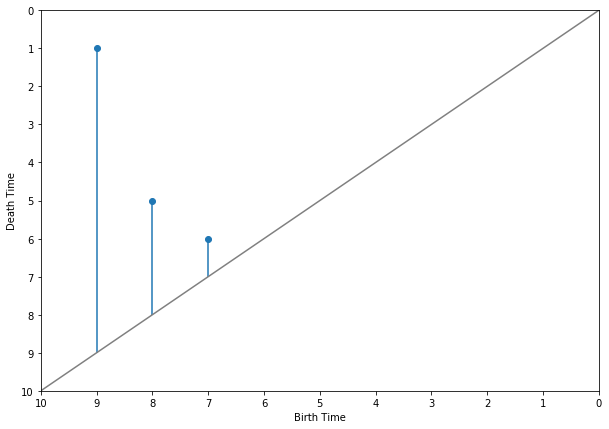

In [237]:
plt.figure(figsize=(10,7))
plt.scatter(xmin, xmax)
plt.vlines(x=xmin, ymin=xmin, ymax=xmax, colors='C0')
plt.xlim(xlim[0], xlim[1])
plt.ylim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Birth Time')
plt.ylabel('Death Time')
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], c='grey')
plt.show()

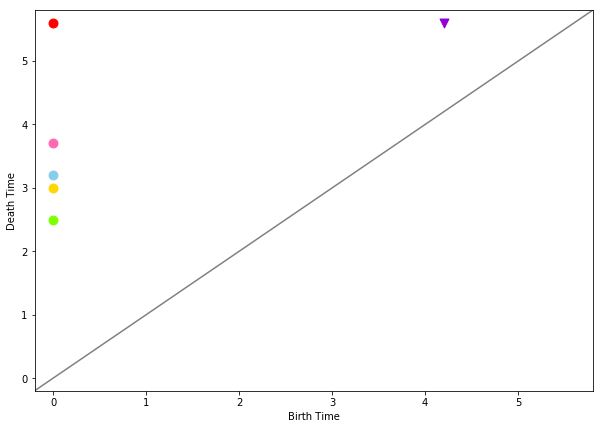

In [20]:
xlim = [-0.2, 5.8]

plt.figure(figsize=(10,7))
plt.scatter(0, 2.5, marker='o', color='chartreuse', s=80)
plt.scatter(0, 3, marker='o', color='gold', s=80)
plt.scatter(0, 3.2, marker='o', color='skyblue', s=80)
plt.scatter(0, 3.7, marker='o', color='hotpink', s=80)
plt.scatter(0, 5.6, marker='o', color='red', s=80)
plt.scatter(4.2, 5.6, marker='v', color='darkviolet', s=80)
plt.xlabel('Birth Time')
plt.ylabel('Death Time')
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], c='grey')
plt.xlim(xlim[0], xlim[1])
plt.ylim(xlim[0], xlim[1])
plt.show()